<div style='background-image: url("../../../share/images/header.svg") ; padding: 0px ; background-size: cover ; border-radius: 5px ; height: 250px'>
    <div style="float: right ; margin: 50px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.7) ; width: 50% ; height: 150px">
        <div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.8) ; line-height: 100%">Computational Seismology</div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.5)"> SBP-SAT finite difference method for the 1D elastic wave equation in first order form </div>
        </div>
    </div>
</div>

This notebook is based on the paper [Dynamic earthquake rupture simulations on nonplanar faults embedded in 3D geometrically complex, heterogeneous Earth models](https://pangea.stanford.edu/~edunham/publications/Duru_Dunham_FD3d_JCP16.pdf), and on the theory of summation-by-parts (SBP) finite difference methods and weak implementation of boundary conditions using the simultaneous-approximation-term (SAT).


##### Authors:
* Kenneth Duru

---

## Basic Equations ##

We consider in this notebook a system of hyperbolic PDE, the elastic wave equation, in 1D. The source-free elastic wave equation in a heterogeneous 1D medium is 

\begin{align}
\rho(x)\frac{\partial v(x,t)}{\partial t} -\frac{\partial\sigma(x,t)}{\partial x} & = 0\\
\frac{1}{\mu(x)}\frac{\partial\sigma(x,t)}{\partial t} -\frac{\partial v(x,t)}{\partial x} & = 0  
\end{align}

with $\rho(x)$ the density, $\mu(x)$ the shear modulus and $x \in [0, L]$. At the boundaries $ x = 0, x = L$ we pose the general well-posed linear boundary conditions

\begin{equation}
\begin{split}
B_0(v, \sigma, Z_{s}, r_0): =\frac{Z_{s}}{2}\left({1-r_0}\right){v} -\frac{1+r_0}{2} {\sigma} = 0,  \quad \text{at} \quad x = 0, \\
 B_L(v, \sigma, Z_{s}, r_n): =\frac{Z_{s}}{2} \left({1-r_n}\right){v} + \frac{1+r_n}{2}{\sigma} = 0, \quad \text{at} \quad  x = L.
 \end{split}
\end{equation}

with the reflection coefficients $r_0$, $r_n$ being real numbers and  $|r_0|, |r_n| \le 1$. 

Note that at $x = 0$,  while  $r_0 = -1$ yields a clamped wall, $r_0 = 0$  yields  an absorbing boundary, and  with $r_0 = 1$  we have a free-surface boundary condition. Similarly, at $x = L$, $r_n = -1$ yields a clamped wall, $r_n = 0$ yields an absorbing boundary, and  $r_n = 1$  gives a free-surface boundary condition.

We introduce the mechanical energy defined by
\begin{equation}
E(t) = \int_0^L{\left(\frac{\rho(x)}{2} v^2(x, t) + \frac{1}{2\mu(x)}\sigma^2(x, t)\right) dx},
\end{equation}

where $E(t)$ is the sum of the kinetic energy and the strain energy.
We have 

\begin{equation}
\frac{d E(t)}{dt} = -v(0, t)\sigma(0, t) + v(L, t)\sigma(L, t) \le 0.
\end{equation}

From the boundary conditions, it is easy to check that  $v(0, t)\sigma(0, t) \ge 0$ and $v(L, t)\sigma(L, t) \le 0$, for all $|r_0|, |r_n| \le 1$. This energy loss through the boundaries is what the numerical method should emulate. 

1) Discretize the spatial domain $x$ into $N$ discrete nodes with the uniform spatial step $\Delta{x} = L/(N-1)$, denote the unknown fields at the nodes: $\mathbf{v}\left(t\right) = [v_1\left(t\right), v_2\left(t\right), \cdots, v_N\left(t\right)]$, and $\boldsymbol{\sigma}\left(t\right) = [\sigma_1\left(t\right), \sigma_2\left(t\right), \cdots, \sigma_N\left(t\right)]$.


2) At the grid-point $x_j = (j-1)\Delta{x}$: Approximate the spatial derivative by a finite difference operator $\partial v/\partial x\Big|_{x = x_j} \approx \left(\mathbf{D}\mathbf{v}\right)_j $. Here $\mathbf{D}$ is a finite difference matrix satisfying the summation-by-parts property:

\begin{align}
\mathbf{H}\mathbf{D} = \mathbf{Q}, \quad \mathbf{Q} + \mathbf{Q} = \left(\boldsymbol{e}_{N}\boldsymbol{e}_{N}^T -\boldsymbol{e}_{1}\boldsymbol{e}_{1}^T\right), \quad \mathbf{H}^T = \mathbf{H} > 0,
\end{align}

where, $\boldsymbol{e}_{0} = [1, 0, \dots,  0 ]^T, \quad  \boldsymbol{e}_{L} = [ 0, 0, \dots,  1 ]^T$ and $\mathbf{H}$ defines a dicrete norm. We consider only diagonal norm SBP operators with $H_{jj} = h_j > 0$, and define the quadrature rule

\begin{equation}
 \sum_{i = 1}^{N} f(x_j)h_j \approx \int_{0}^{L}f(x) dx.
\end{equation}

The second order accurate SBP operator for the first derivative is:
\begin{align}
\left(\mathbf{D}\mathbf{v}\right)_j = \frac{v_{j+1}-v_{j-1}}{2 \Delta{x}}, \quad j = 2, 3, \cdots N-1, \quad
\left(\mathbf{D}\mathbf{v}\right)_1 = \frac{v_{2}-v_{1}}{\Delta{x}},\quad
\left(\mathbf{D}\mathbf{v}\right)_N = \frac{v_{N}-v_{N-1}}{\Delta{x}}, \quad j = N.
\end{align}

Note that the interior stencils are centered, with second order accuracy and the boundary stencils are one-sided and first order accurate. 

Higher order SBP operators can be found in the book: High Order Difference Methods for Time Dependent PDE, by B. Gustafsson. In this notebook we implement SBP operators with interior accuracy 2, 4 and 6. The implementation of the spatial derivative operators can be found in the file first_derivative_sbp_operators.py

To construct a stable  semi-discrete approximation we replace the spatial derivatives by the SBP operators, and add the boundary conditions as SAT-terms with special penalty weights having:

\begin{align}
\frac{d \mathbf{v}(t)}{d t} = {\boldsymbol{\rho}}^{-1}
\left(\mathbf{D} \boldsymbol{\sigma}(t) - \underbrace{\mathbf{H}^{-1}\left(\tau_{11}\boldsymbol{e}_{1}B_0\left(v_1, \sigma_1, Z_{s}, r_0\right) + \tau_{12}\boldsymbol{e}_{N}B_L\left(v_N, \sigma_N, Z_{s}, r_n\right)\right)}_{SAT \to 0}\right),
\end{align}

\begin{align}
\frac{d \boldsymbol{\sigma}(t)}{d t} = \boldsymbol{\mu}
\left(\mathbf{D} \mathbf{v}(t) + \underbrace{\mathbf{H}^{-1}\left(\tau_{21}\frac{\boldsymbol{e}_{1}}{Z_{s}}B_0\left(v_1, \sigma_1, Z_{s}, r_0\right) - \tau_{22}\frac{\boldsymbol{e}_{N}}{Z_{s}}B_L\left(v_N, \sigma_N, Z_{s}, r_n\right)\right)}_{SAT \to 0}\right).
\end{align}
Here $\tau_{ij}$ are penalty parameters determined by requiring stability.

Approximate the mechanical energy by the above quadrature rule, having 
\begin{align}
\mathcal{E}( t) = \sum_{j}^{N}\frac{1}{2}\left(\rho_jv_j^2 + \frac{1}{\mu_j}\sigma_j^2\right)h_j > 0.
\end{align}

By chosing the penalty parameters $\tau_{ij} = 1$, the semi-discrete approximation satisfies the energy estimate:
\begin{align}
\frac{d \mathcal{E}( t)}{d t} = -\frac{1}{2}\left(\left(1-r_0\right)Zv_1^2 + \frac{\left(1+r_0\right)}{Z}\sigma_1^2 +
\left(1-r_n\right)Zv_N^2 + \frac{\left(1+r_n\right)}{Z}\sigma_N^2\right) \le 0.
\end{align}


3) The discrete mechanical energy can never grow in time, and thus the semidiscrete numerical approximation is asymptotically stable.

4)  Time integration can be performed using any stable time stepping scheme. This notebook implements the fourth order accurate Runge-Kutta method. 

To keep the problem simple, we use as spatial initial condition a Gauss function with half-width $\delta$

\begin{equation}
v(x,t=0)  = e^{-1/\delta^2 (x - x_{o})^2}, \quad \sigma(x,t=0) = 0
\end{equation}

**** Exercises****



In [1]:
# Parameters initialization and plotting the simulation
# Import necessary routines
import numpy as np
import matplotlib.pyplot as plt
import time_integrator
import rate
import utils
import timeit

#plt.switch_backend("TkAgg")          # plots in external window
plt.switch_backend("nbagg")           # plots within this notebook

In [2]:
# Initializations
L = 10.0         # length of the domain (km)
t = 0.0          # initial time
tend = 1.45      # final time
nx = 501        # grid points in x                                                                                                                       
dx = L/(nx-1)    # grid increment in x
cs = 3.464       # velocity (km/s) (can be an array)                                                                                                             
iplot = 5       # snapshot frequency
rho = 2.6702     # density [g/cm^3]
mu = rho*cs**2   # shear modulus [GPa]
Zs = rho*cs      # shear impedance 

order = 6        # order of accuracy


#Initialize the domain
y = np.zeros((nx, 1))

# Initial particle velocity perturbation and discretize the domain
for j in range(0, nx):
    y[j, :] = j*dx                                             # discrete domain



# Time stepping parameters
cfl = 1.0                         # CFL number
dt = (cfl/cs)*dx                  # Time step
nt = int(round(tend/dt))          # number of time steps
n = 0                             # counter

# Boundary condition reflection coefficients 
r0 = 1                            # r=0:absorbing, r=1:free-surface, r=-1: clamped 
r1 = 1                            # r=0:absorbing, r=1:free-surface, r=-1: clamped

# penalty parameters
tau_11 = 1 
tau_12 = 1
tau_21 = 1 
tau_22 = 1

# Initialize: particle velocity (v); and shear stress (s)
v = np.zeros((nx, 1))
s = np.zeros((nx, 1))

U = np.zeros((nx, 1))
V = np.zeros((nx, 1))
U_t = np.zeros((nx, 1))
V_t = np.zeros((nx, 1))
U_x = np.zeros((nx, 1))
V_x = np.zeros((nx, 1))

                                

# Difference between analyticla and numerical solutions
EV = [0]                                 # initialize errors in V (velocity)
EU = [0]                                 # initialize errors in U (stress)
T = [0]                                  # later append every time steps to this

<IPython.core.display.Javascript object>


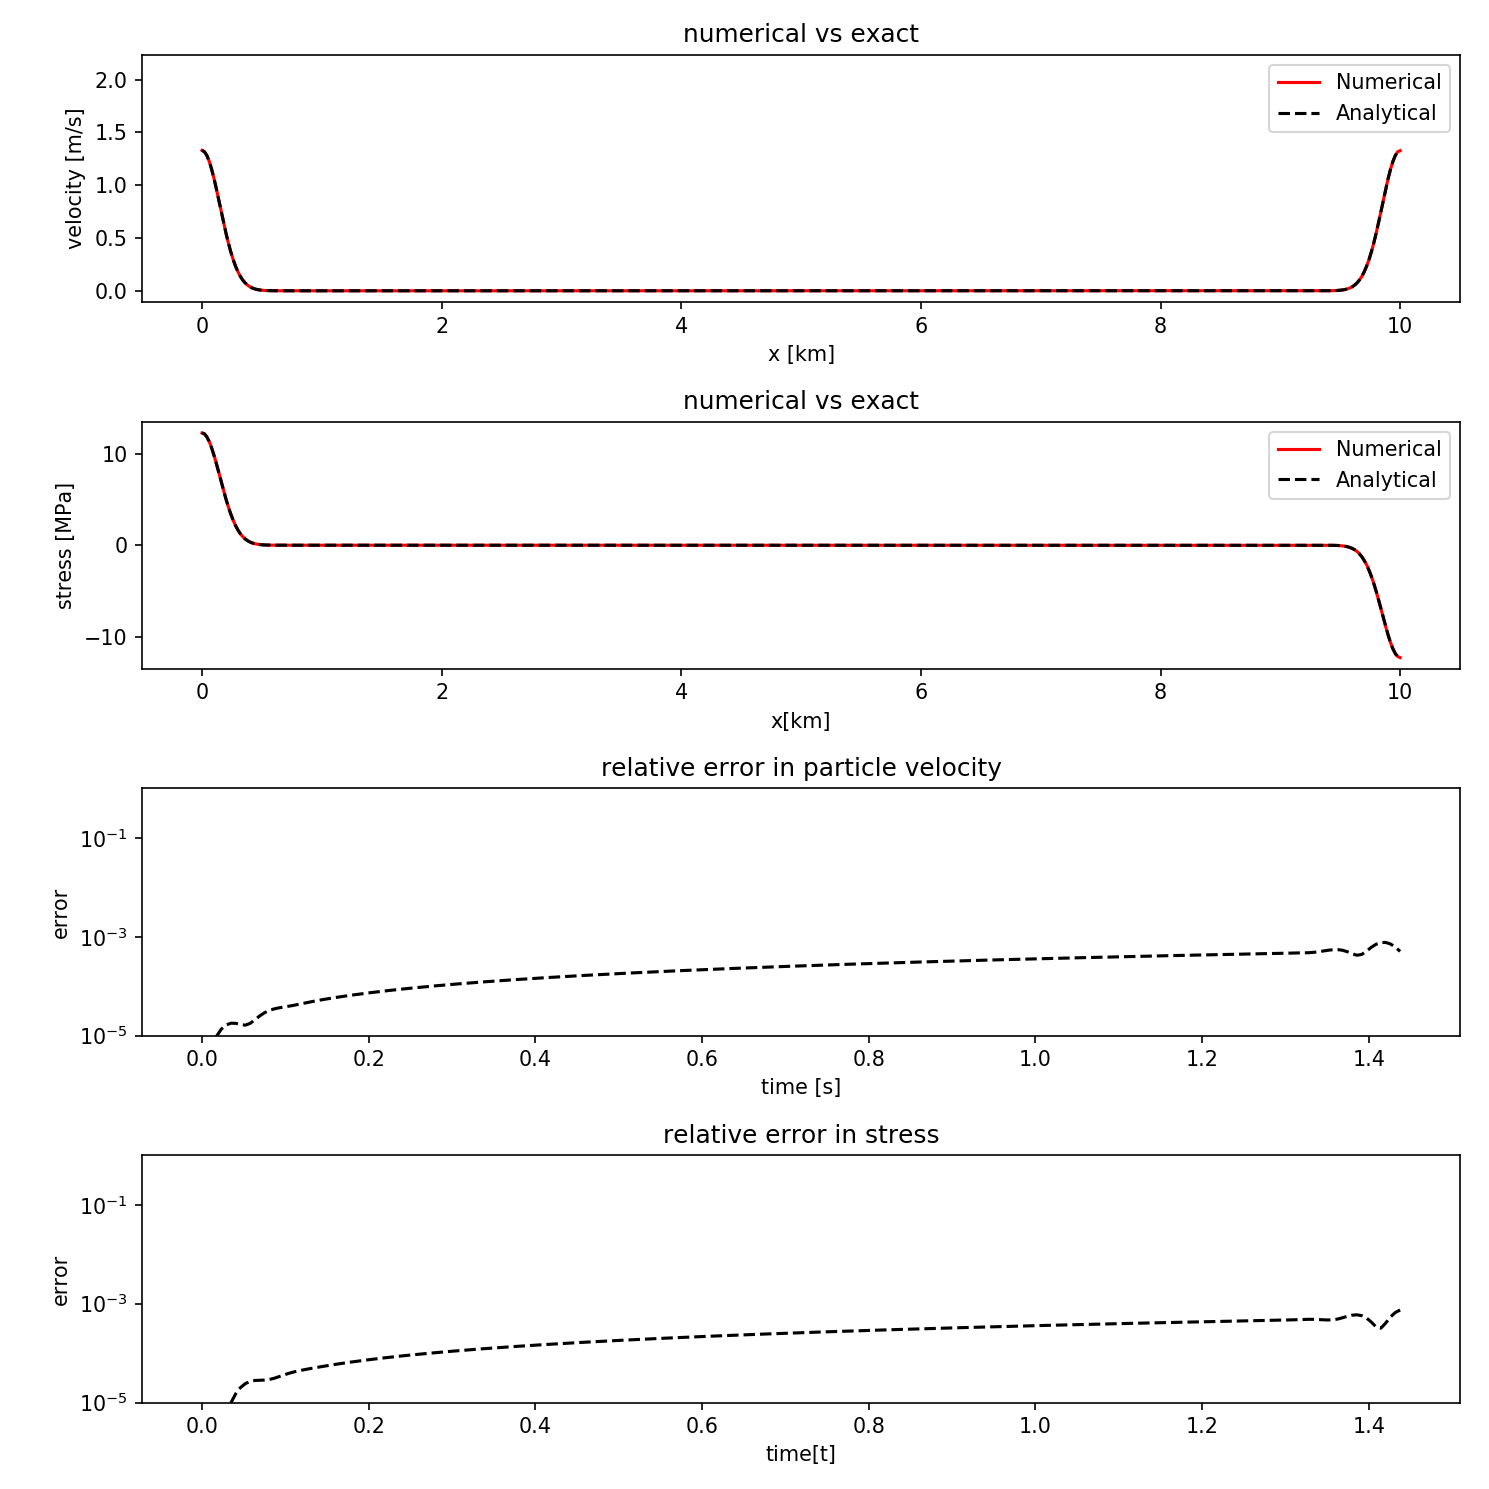

total simulation time =  17.996436359313172
spatial order  of accuracy =  6
number of grid points =  501
maximum relative error in particle velocity =  0.000769068946601
maximum relative error in stress =  0.000765227081054


In [3]:
# Computation and plotting

# Initialize animated plot for velocity and stress
fig1 = plt.figure(figsize=(10,10))
ax1 = fig1.add_subplot(4,1,1)
line1 = ax1.plot(y, v, 'r', y, U, 'k--')
plt.title('numerical vs exact')
plt.xlabel('x [km]')
plt.ylabel('velocity [m/s]')

ax2 = fig1.add_subplot(4,1,2)
line2 = ax2.plot(y, s, 'r', y, V, 'k--')
plt.title('numerical vs exact')
plt.xlabel('x[km]')
plt.ylabel('stress [MPa]')

# Initialize error plot (for velocity and stress)
ax3 = fig1.add_subplot(4,1,3)
line3 = ax3.plot(T, EV, 'r')
plt.title('relative error in particle velocity')
plt.xlabel('time [s]')
ax3.set_ylim([10**-5, 1])
plt.ylabel('error')

ax4 = fig1.add_subplot(4,1,4)
line4 = ax4.plot(T, EU, 'r') 
plt.ylabel('error')
plt.xlabel('time[t]')
ax4.set_ylim([10**-5, 1])
plt.title('relative error in stress')

plt.tight_layout()
plt.ion()
plt.show()


t=0   # initial time

forcing = 1.0  # forcing function, forcing = 1,  and no forcing function, forcing = 0

# type of initial data: Gaussian or Sinusoidal
type_0 = 'Gaussian'
#type_0 = 'Sinusoidal'


if type_0 in ('Sinusoidal'):
            forcing = 1.0  # we must use forcing for Sinusoidal initial condition

# L2-norm normalizer
# Generate  conditions for normalization
rate.mms(v, s, U_t, V_t, U_x, V_x, y, 0.65, type_0)
A =  (np.linalg.norm(v)) 
B =  (np.linalg.norm(s))


# Loop through time and evolve the wave-fields using ADER time-stepping scheme of N+1 order of accuracy
start = timeit.default_timer()

# Generate initial conditions
rate.mms(v, s, U_t, V_t, U_x, V_x, y, t, type_0)

for t in utils.drange (0.0, tend+dt,dt):
    n = n+1
    
    # compute numerical solution 
    time_integrator.elastic_RK4(v, s, v, s, rho, mu, nx, dx, order, y, t, dt, r0, r1,  tau_11,\
                    tau_21, tau_12, tau_22, type_0, forcing)
 
    # Analytical solution
    rate.mms(U, V, U_t, V_t, U_x, V_x, y, t+dt, type_0)
    
    # compute error and append to the error array
    EU.append(np.linalg.norm(U-v)/A)
    EV.append(np.linalg.norm(V-s)/B)
    
    
    T.append(t)

    # Updating plots
    if n % iplot == 0: 
        for l in line1:
            l.remove()
            del l               
        for l in line2:
            l.remove()
            del l
        for l in line3:
            l.remove()
            del l               
        for l in line4:
            l.remove()
            del l 

        # Display lines
        line1 = ax1.plot(y, v, 'r', y, U, 'k--')
        ax1.legend(iter(line1),('Numerical', 'Analytical'))
        line2 = ax2.plot(y, s, 'r', y, V, 'k--')
        ax2.legend(iter(line2),('Numerical', 'Analytical'))
        line3 = ax3.plot(T, EU, 'k--')
        ax3.set_yscale("log")#, nonposx='clip')
        line4 = ax4.plot(T, EV, 'k--')
        ax4.set_yscale("log")#, nonposx='clip')
        plt.gcf().canvas.draw()
       
plt.ioff()
plt.show()

# Simulation end time
stop = timeit.default_timer()
print('total simulation time = ', stop - start)                   # print the time required for simulation
print('spatial order  of accuracy = ', order)                                  # print the polynomial degree used
print('number of grid points = ', nx)                     # print the degree of freedom
print('maximum relative error in particle velocity = ', max(EU))  # max. relative error in particle velocity
print('maximum relative error in stress = ', max(EV))             # max. relative error in stress